In [1]:
import random
import seaborn as sns
import matplotlib.pyplot as mpl

import pyspark as ps
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.dataframe import DataFrame
from pyspark.sql.context import SQLContext

import pandas as pd
from pandas.core.frame import DataFrame as PDataFrame

%matplotlib inline

In [2]:
# Define number of players to be used as reference
# for Spark-ML training process
NUM_RANDOM_PLAYERS = 100

# Define number of players to display
NUM_PLAYERS_DISPLAY_STD_COUT = 20

In [3]:
def quartiles_resolver(df:DataFrame, col:str)->type(tuple):
    ordered_df = df.orderBy(col)
    count = ordered_df.count()
    quot = count >> 1
    rem = count % 2
    m_index = quot if rem == 0 else quot + rem
    p_df = ordered_df.select('*').toPandas()
    q1 = p_df[col][m_index - 1 :].mean()
    q2 = p_df[col][m_index]
    q3 = p_df[col][: m_index].mean()
    return (q1, q2, q3, p_df)

def interquartile_infos(df:DataFrame, col:str)->type(tuple):
    q1, q2, q3, p_df = quartiles_resolver(df, col)
    v_min = p_df[col].min()
    v_max = p_df[col].max()
    v_med = p_df[col].mean()
    return v_min, v_max, v_med, q1, q2, q3, p_df

def get_random_player_ids(amount:int, list_len:int)->type(list):
    return random.sample(range(0, list_len), amount)

In [4]:
# Quad-core parallel processing
spark = ps.sql.SparkSession.builder\
    .master('local[4]')\
    .appName('spark-ml')\
    .getOrCreate()

# Disable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "false")

In [5]:
df = SQLContext(spark.sparkContext).read.csv(
    path='../Datasets/data.csv',
    header=True,
    quote='"',
    sep=",",
    inferSchema=True
)

In [6]:
filtered_df = df[[
    'ID',
    'Name',
    'Age',
    'Nationality',
    'Overall',
    'Potential',
    'Club',
    'Value',
    'International Reputation',
    'Release Clause'
]]

In [7]:
filtered_df.show(NUM_PLAYERS_DISPLAY_STD_COUT)

+------+-----------------+---+-----------+-------+---------+-------------------+-------+------------------------+--------------+
|    ID|             Name|Age|Nationality|Overall|Potential|               Club|  Value|International Reputation|Release Clause|
+------+-----------------+---+-----------+-------+---------+-------------------+-------+------------------------+--------------+
|158023|         L. Messi| 31|  Argentina|     94|       94|       FC Barcelona|€110.5M|                       5|       €226.5M|
| 20801|Cristiano Ronaldo| 33|   Portugal|     94|       94|           Juventus|   €77M|                       5|       €127.1M|
|190871|        Neymar Jr| 26|     Brazil|     92|       93|Paris Saint-Germain|€118.5M|                       5|       €228.1M|
|193080|           De Gea| 27|      Spain|     91|       93|  Manchester United|   €72M|                       4|       €138.6M|
|192985|     K. De Bruyne| 27|    Belgium|     91|       92|    Manchester City|  €102M|         

In [8]:
min_scr, max_scr, median, q1, q2, q3, filtered_p_df = interquartile_infos(filtered_df, 'Age')

min: 16
max: 45
median: 25.122205745043114 (IQR: 25)
lower quartile: 28.967157293497365
upper quartile: 21.27724077328647


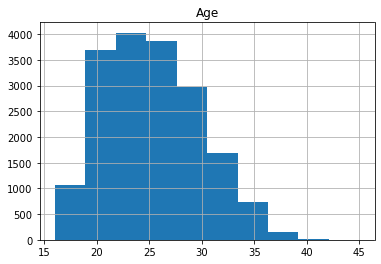

In [9]:
filtered_p_df.hist(['Age'])
print("min: {}".format(min_scr))
print("max: {}".format(max_scr))
print("median: {} (IQR: {})".format(median, q2))
print("lower quartile: {}".format(q1))
print("upper quartile: {}".format(q3))
mpl.show()

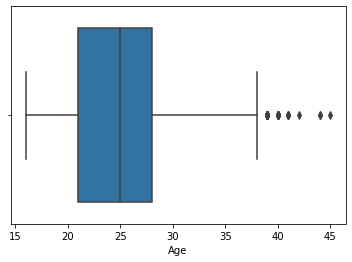

In [10]:
ax = sns.boxplot(x=filtered_p_df['Age'])
mpl.show()

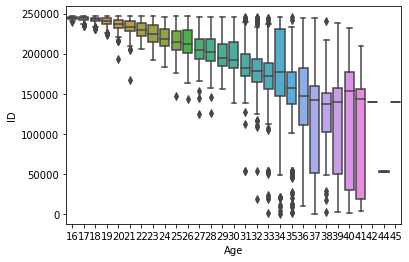

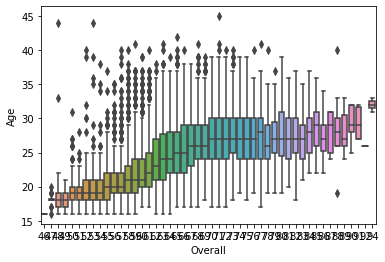

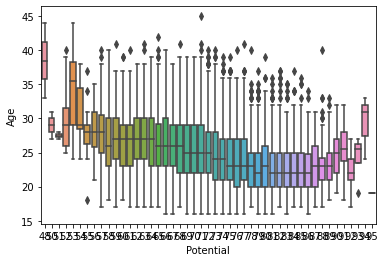

In [11]:
ax = sns.boxplot(x=filtered_p_df['Age'], y=filtered_p_df['ID'])
mpl.show()
ax = sns.boxplot(y=filtered_p_df['Age'], x=filtered_p_df['Overall'])
mpl.show()
ax = sns.boxplot(y=filtered_p_df['Age'], x=filtered_p_df['Potential'])
mpl.show()

In [12]:
rnd_player_ids = get_random_player_ids(NUM_RANDOM_PLAYERS, len(filtered_p_df))

In [13]:
rnd_df = PDataFrame(columns=filtered_p_df.columns)

In [14]:
for rnd_player_id in rnd_player_ids:
    rnd_player = []
    for column in rnd_df.columns:
        rnd_player.append(filtered_p_df[column][rnd_player_id])
    rnd_df.loc[len(rnd_df)] = rnd_player

In [15]:
rnd_df.head(NUM_PLAYERS_DISPLAY_STD_COUT)

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,International Reputation,Release Clause
0,216154,J. Elsey,24,Australia,66,69,Adelaide United,€675K,1.0,€894K
1,232929,M. Mihara,29,Japan,66,66,Vissel Kobe,€475K,1.0,€594K
2,210213,G. Korte,24,Netherlands,66,68,NAC Breda,€800K,1.0,€1.2M
3,209988,L. Ayçiçek,24,Germany,67,72,SpVgg Greuther Fürth,€1M,1.0,€1.7M
4,241947,F. Amuzu,18,Belgium,67,81,RSC Anderlecht,€1.6M,1.0,€3.3M
5,204226,D. Lezcano,28,Paraguay,72,72,FC Ingolstadt 04,€3.2M,1.0,€5.1M
6,243729,N. Sette,18,Australia,53,67,Melbourne Victory,€120K,1.0,€225K
7,234177,N. Ennis,19,England,58,75,Wolverhampton Wanderers,€280K,1.0,€707K
8,232523,B. Trawally,23,Gambia,72,78,Guizhou Hengfeng FC,€4.3M,1.0,€10.2M
9,215111,G. Verón,28,Argentina,71,71,Independiente,€2.4M,1.0,€3.4M


In [16]:
df = spark.createDataFrame(rnd_df)

In [17]:
df.show(NUM_PLAYERS_DISPLAY_STD_COUT)

+------+-------------+---+--------------+-------+---------+--------------------+-----+------------------------+--------------+
|    ID|         Name|Age|   Nationality|Overall|Potential|                Club|Value|International Reputation|Release Clause|
+------+-------------+---+--------------+-------+---------+--------------------+-----+------------------------+--------------+
|216154|     J. Elsey| 24|     Australia|     66|       69|     Adelaide United|€675K|                     1.0|         €894K|
|232929|    M. Mihara| 29|         Japan|     66|       66|         Vissel Kobe|€475K|                     1.0|         €594K|
|210213|     G. Korte| 24|   Netherlands|     66|       68|           NAC Breda|€800K|                     1.0|         €1.2M|
|209988|   L. Ayçiçek| 24|       Germany|     67|       72|SpVgg Greuther Fürth|  €1M|                     1.0|         €1.7M|
|241947|     F. Amuzu| 18|       Belgium|     67|       81|      RSC Anderlecht|€1.6M|                     1.0|

In [18]:
df.printSchema()

root
 |-- ID: long (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Overall: long (nullable = true)
 |-- Potential: long (nullable = true)
 |-- Club: string (nullable = true)
 |-- Value: string (nullable = true)
 |-- International Reputation: double (nullable = true)
 |-- Release Clause: string (nullable = true)



In [19]:
ml_asm = VectorAssembler(
    inputCols=['Age', 'Overall', 'Potential', 'International Reputation'],
    outputCol='Features'
)
ml_vasm = ml_asm.transform(df)

In [20]:
ml_vasm.select(['ID', 'Name', 'Features']).show(NUM_PLAYERS_DISPLAY_STD_COUT)

+------+-------------+--------------------+
|    ID|         Name|            Features|
+------+-------------+--------------------+
|216154|     J. Elsey|[24.0,66.0,69.0,1.0]|
|232929|    M. Mihara|[29.0,66.0,66.0,1.0]|
|210213|     G. Korte|[24.0,66.0,68.0,1.0]|
|209988|   L. Ayçiçek|[24.0,67.0,72.0,1.0]|
|241947|     F. Amuzu|[18.0,67.0,81.0,1.0]|
|204226|   D. Lezcano|[28.0,72.0,72.0,1.0]|
|243729|     N. Sette|[18.0,53.0,67.0,1.0]|
|234177|     N. Ennis|[19.0,58.0,75.0,1.0]|
|232523|  B. Trawally|[23.0,72.0,78.0,1.0]|
|215111|     G. Verón|[28.0,71.0,71.0,1.0]|
|234671|   J. Odgaard|[19.0,62.0,80.0,1.0]|
|142270|   J. Thomsen|[36.0,67.0,67.0,1.0]|
|220132|       Zaldúa|[26.0,75.0,78.0,1.0]|
|246399|     C. Björk|[18.0,50.0,70.0,1.0]|
|245598|      I. Baba|[22.0,60.0,69.0,1.0]|
|214613|   F. Micolta|[28.0,67.0,67.0,1.0]|
|240620|        A. Ba|[20.0,58.0,66.0,1.0]|
|191910|Kim Shin Wook|[30.0,69.0,69.0,2.0]|
|214226|    R. Loaiza|[24.0,70.0,78.0,1.0]|
|238033|      F. Nita|[30.0,71.0

In [21]:
df_parts = ml_vasm.randomSplit([0.7, 0.3])
training_df = df_parts[0]
testing_df = df_parts[1]

In [22]:
training_df.describe(['Name', 'Age', 'Overall', 'Potential', 'International Reputation']).show(NUM_PLAYERS_DISPLAY_STD_COUT)

+-------+-----------+-----------------+-----------------+-----------------+------------------------+
|summary|       Name|              Age|          Overall|        Potential|International Reputation|
+-------+-----------+-----------------+-----------------+-----------------+------------------------+
|  count|         74|               74|               74|               74|                      74|
|   mean|       null|24.93243243243243|64.98648648648648|70.06756756756756|       1.027027027027027|
| stddev|       null|4.298235002789832|5.742161406918355|5.422760458338794|     0.16326908396901554|
|    min|A. Arellano|               18|               50|               56|                     1.0|
|    max|     Zaldúa|               37|               79|               86|                     2.0|
+-------+-----------+-----------------+-----------------+-----------------+------------------------+



In [23]:
testing_df.describe(['Age', 'Overall', 'Potential', 'International Reputation']).show(NUM_PLAYERS_DISPLAY_STD_COUT)

+-------+------------------+-----------------+-----------------+------------------------+
|summary|               Age|          Overall|        Potential|International Reputation|
+-------+------------------+-----------------+-----------------+------------------------+
|  count|                26|               26|               26|                      26|
|   mean|23.923076923076923|66.03846153846153|71.92307692307692|      1.1153846153846154|
| stddev| 4.740658831201224|7.602529943279511|6.560018761699251|      0.4314554973040049|
|    min|                17|               52|               63|                     1.0|
|    max|                35|               82|               87|                     3.0|
+-------+------------------+-----------------+-----------------+------------------------+



In [27]:
ml_lr = LinearRegression(
    featuresCol='Features',
    labelCol='Potential',
    predictionCol='Potential (Prediction)'
)
ml_lr_model = ml_lr.fit(training_df)

In [28]:
ml_lr_preds = ml_lr_model.transform(testing_df)

In [29]:
ml_lr_preds.select(['Age', 'Overall', 'Potential', 'International Reputation', 'Potential (Prediction)']).show(NUM_PLAYERS_DISPLAY_STD_COUT)

+---+-------+---------+------------------------+----------------------+
|Age|Overall|Potential|International Reputation|Potential (Prediction)|
+---+-------+---------+------------------------+----------------------+
| 35|     65|       65|                     1.0|     64.99999999999993|
| 24|     66|       68|                     1.0|     68.00000000000007|
| 24|     76|       79|                     1.0|     79.00000000000001|
| 28|     67|       67|                     1.0|     67.00000000000003|
| 30|     71|       71|                     1.0|     70.99999999999997|
| 18|     53|       67|                     1.0|     67.00000000000001|
| 29|     73|       73|                     2.0|     73.00000000000001|
| 28|     71|       71|                     1.0|     71.00000000000001|
| 28|     63|       63|                     1.0|     63.00000000000005|
| 23|     71|       77|                     1.0|                  77.0|
| 20|     69|       77|                     1.0|     77.00000000